In [457]:
#必要なライブラリをインポートしておく
import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize
import time
%matplotlib inline

In [500]:
#物理定数
g = 9.81

#分割数・断面間距離[m]
imax = 101
xmax = 5000
chlen = 5000
dx = xmax/(imax-1)

#勾配・川幅
slope0 = 1/1000
w0 = 200.
n0 = 0.02

#流量[m3/s]
q_up = 2000.

#時間
tuk   = 6000.
etime = tuk*60.
dt = 0.02

In [501]:
h  = np.zeros(imax+1)
u  = np.zeros(imax+1)
q  = np.zeros(imax+1)
z0 = np.zeros(imax+1)
wu = np.zeros(imax+1)
q  = np.zeros(imax+1)
wl = np.zeros(imax+1)

In [502]:
x = np.linspace(0,xmax + dx, imax+1)

In [503]:
#河床高
z0 = - slope0 * x

n1 = int(0.4*imax)
n2 = int(0.5*imax)

z0[n1:n2] = z0[n1:n2]+0.1

In [504]:
h0 = (n0*q_up/(w0*slope0**0.5))**(2/3)

In [505]:
h[1:]  = h0
u[1:]  = q_up/(h0*w0)
q[1:]  = q_up/w0

In [506]:
#下流端水位設定
h[0]  = h0
u[0]  = q_up/(h[0]*w0)
q[0]  = q_up/w0

In [507]:
#@jit(nopython=True)
def h_cal(h,u,z0,wu,q,g,dx,dt,n0):
    
    h_bar = np.zeros(imax+1)
    press = np.zeros(imax+1)
    rough = np.zeros(imax+1)
    advec = np.zeros(imax+1)
    nh = np.zeros(imax+1)
    
    h_bar[1:-1] = (h[1:-1]+h[2:])*0.5
    #press[1:-1] = -g*(-h[1:-1]+h[2:])/dx -g*(-z0[1:-1]+z0[2:])/dx
    press[1:-1] = -g*(np.diff(h[1:]))/dx -g*(np.diff(z0[1:]))/dx
    rough[1:-1] = g*n0**2.0*u[1:-1]/h_bar[1:-1]**(4.0/3.0)
    #advec[1:-1] = u[1:-1]*(-u[:-2]+u[1:-1])/dx
    advec[1:-1] = u[1:-1]*(np.diff(u[:-1]))/dx
    
    wu[1:-1] = (u[1:-1]+(-advec[1:-1]+press[1:-1])*dt)/(1.0+rough[1:-1]*dt)
    q[1:-1]  = wu[1:-1]*h_bar[1:-1]
    
    u[1:-1] = wu[1:-1]
    u[imax] = u[imax-1]
    q[imax] = q[imax-1]

    nh[1:-1] = h[1:-1]-(-q[0:-2]+q[1:-1])/dx*dt
    
    h[1:-1] = nh[1:-1]
    h[imax] = h[imax-1]
    
    return[wu,q,h]
    

In [508]:
t = 0.
optime = 0.
n = 0

start time :  1594780879.6857216
Time=  1.666666666677257
Time=  3.333333333380303
Time=  5.000000000083349
Time=  6.666666666786395
Time=  8.333333333489442
Time=  10.000000000029182
Time=  11.666666666429064
Time=  13.333333332828946
Time=  14.999999999228827
Time=  16.66666666562871
Time=  18.33333333207548
Time=  19.99999999908169
Time=  21.666666666087902
Time=  23.333333333094114
Time=  25.000000000100325
Time=  26.666666667106536
Time=  28.333333334112748
Time=  30.00000000111896
Time=  31.66666666812517
Time=  33.33333333513138
Time=  35.00000000213759
Time=  36.66666666895624
Time=  38.333333334749796
Time=  40.000000000543345
Time=  41.666666666336894
Time=  43.33333333213045
Time=  44.999999997924
Time=  46.66666666371755
Time=  48.333333329511106
Time=  49.999999995304655
Time=  51.666666661098205
Time=  53.33333332689176
Time=  54.99999999268531
Time=  56.66666665847886
Time=  58.33333332427242
Time=  59.999999990065966
Time=  61.666666655859515
Time=  63.33333332165307
Ti

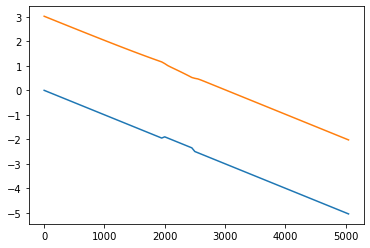

In [509]:
t0 = time.time()
print("start time : ", str(t0))   

while t<etime:
    
    h[0]  = h[1]
    u[0]  = q_up/(h[0]*w0)
    q[0]  = q_up/w0
    
    h_cal(h,u,z0,wu,q,g,dx,dt,n0)
    
    wl = h + z0

    if optime>tuk:
        print("Time= ",t/3600)
        optime = optime-tuk
        #print(h)
    
    optime+=dt
    t+=dt
    
plt.plot(x,z0)
plt.plot(x,wl)

t1 = time.time()
print("End time : ", str(t1))
print("Elapsed : ", str(t1 - t0))

#slice: Elapsed :  96.71032643318176 Elapsed :  1095.9524114131927
#jit slice: Elapsed :  88.6339180469513 Elapsed :  309.5418939590454
#jit diff: Elapsed :  93.5250837802887 Elapsed :  340.5067973136902